Aim:
Finding a suitable model for classification of leukemic B-lymphoblast cells from normal B-lymphoid precursors from blood smear microscopic images. 

We have used a CNN model and some pretrained models like ResNet50, VGG16, VGG19 and InceptionV3 in this process.
After training the models for 15 epochs, the VGG19 model came up with the highest accuracy among all of them with about ~78% accuracy and VGG16 was the second highest with a little less accuracy than the former with about ~77%.

The reason behind VGG models getting so much higher accuracy in comparison to others is its architecture, the main key points of this architecture are as follows: 

*    Use of very small convolutional filters, e.g. 3×3 and 1×1 with a stride of one.
*    Use of max pooling with a size of 2×2 and a stride of the same dimensions.
*    The importance of stacking convolutional layers together before using a pooling layer to define a block.
*    Dramatic repetition of the convolutional-pooling block pattern.
*    Development of very deep (16 and 19 layer) models.




In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import sys
print(os.listdir("../input"))
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)
# Any results you write to the current directory are saved as output.

['blood-cancer-test-dataset', 'blood-cancer-training-dataset']


In [4]:
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, DepthwiseConv2D
from keras import backend as K
import itertools
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [5]:
os.listdir("../input")

['blood-cancer-test-dataset', 'blood-cancer-training-dataset']

In [6]:
# This cell can be used to access and use the TEST dataset available

# data = pd.read_csv("../input/blood-cancer-test-dataset/c-nmc_test_prelim_phase_data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data_labels.csv")
# print(data.head())

# baseadd = "../input/blood-cancer-test-dataset/c-nmc_test_prelim_phase_data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data"
# image_path_dict = {os.path.basename(x): x for x in glob(os.path.join(baseadd, "*.bmp"))}
# data["path"] = (data["new_names"]).map(image_path_dict.get)
# data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((224, 224))))
# data["image"].shape
# print(data.head())

# data["Patient_ID"][0].split('_')
# subject_id_dict = {data["Patient_ID"][x]: data["Patient_ID"][x].split("_")[1] for x in range(len(data["Patient_ID"]))}
# image_id_dict = {data["Patient_ID"][x]: data["Patient_ID"][x].split("_")[2] for x in range(len(data["Patient_ID"]))}
# cell_id_dict = {data["Patient_ID"][x]: data["Patient_ID"][x].split("_")[3] for x in range(len(data["Patient_ID"]))}

# data["subject_id"] = data["Patient_ID"].map(subject_id_dict.get)
# data["image_id"] = data["Patient_ID"].map(image_id_dict.get)
# data["cell_no"] = data["Patient_ID"].map(cell_id_dict.get)
# # data["cell_state"] = data["Patient_ID"].map(cell_type_id_dict.get)
# subject_filter_dict = {data["subject_id"][x]: data["subject_id"][x][1:] if "H" in data["subject_id"][x] 
#                        else data["subject_id"][x] for x in range(len(data["Patient_ID"]))}
# data["subject_id"] = data["subject_id"].map(subject_filter_dict.get)
# print(data.sample(5))

# plt.imshow(data["image"][0])
# plt.axis("off")

# data["labels"].value_counts().plot(kind = "bar")
# print(data["labels"].value_counts())

# plt.scatter(data['subject_id'], data['cell_no'])
# plt.title("Subject Id distribution")

# data['subject_id'].value_counts().plot(kind = 'bar')
# plt.title("Subject Id dis")

## Preprocessing the data

In [7]:
baseadd_tr = "../input/blood-cancer-training-dataset/c-nmc_training_data(1)/C-NMC_training_data"
image_path_dict_tr = {os.path.basename(x).split(".")[0]: x for x in glob(os.path.join(baseadd_tr, "*", "*", "*.bmp"))}

In [8]:
data_tr = pd.DataFrame()
password = [os.path.basename(x).split(".")[0] for x in glob(os.path.join(baseadd_tr, "*", "*", "*.bmp"))]
data_tr["Patient_ID"] = password
data_tr.head()

,Patient_ID
0,UID_H14_26_1_hem
1,UID_H10_63_1_hem
2,UID_H14_30_6_hem
3,UID_H10_190_3_hem
4,UID_H14_19_15_hem


In [9]:
data_tr["path"] = data_tr["Patient_ID"].map(image_path_dict_tr.get)
data_tr['image'] = data_tr['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 100))))
data_tr.head()

,Patient_ID,path,image
0,UID_H14_26_1_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,UID_H10_63_1_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,UID_H14_30_6_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,UID_H10_190_3_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,UID_H14_19_15_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [10]:
data_tr["image"].shape

(10661,)

In [11]:
data_tr["Patient_ID"][0].split('_')
subject_id_dict_tr = {data_tr["Patient_ID"][x]: data_tr["Patient_ID"][x].split("_")[1] for x in range(len(data_tr["Patient_ID"]))}
image_id_dict_tr = {data_tr["Patient_ID"][x]: data_tr["Patient_ID"][x].split("_")[2] for x in range(len(data_tr["Patient_ID"]))}
cell_id_dict_tr = {data_tr["Patient_ID"][x]: data_tr["Patient_ID"][x].split("_")[3] for x in range(len(data_tr["Patient_ID"]))}
data_tr["subject_id"] = data_tr["Patient_ID"].map(subject_id_dict_tr.get)
data_tr["image_id"] = data_tr["Patient_ID"].map(image_id_dict_tr.get)
data_tr["cell_no"] = data_tr["Patient_ID"].map(cell_id_dict_tr.get)
# data["cell_state"] = data["Patient_ID"].map(cell_type_id_dict.get)
subject_filter_dict_tr = {data_tr["subject_id"][x]: data_tr["subject_id"][x][1:] if ("H") in data_tr["subject_id"][x] 
                       else data_tr["subject_id"][x] for x in range(len(data_tr["Patient_ID"]))}
data_tr["subject_id"] = data_tr["subject_id"].map(subject_filter_dict_tr.get)
data_tr.sample(5)

,Patient_ID,path,image,subject_id,image_id,cell_no
3222,UID_33_24_3_all,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",33,24,3
4145,UID_H23_4_4_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",23,4,4
9183,UID_26_19_5_all,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",26,19,5
8242,UID_H15_19_7_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",15,19,7
6922,UID_13_3_1_all,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",13,3,1


In [12]:
# 0 means normal cell, while 1 means a cancer diagnosed cell
label_dict = {password[x] : password[x].split("_")[-1] for x in range(len(password))}
data_tr["labels"] = data_tr["Patient_ID"].map(label_dict.get)
data_tr["labels"] = data_tr["labels"].apply(lambda x: 1 if x == 'all' else 0).astype(np.bool)
data_tr["subject_id"] = data_tr["subject_id"].apply(lambda x: "3" if x == "h3" else x)

In [13]:
# Deleting dicts and list whose work is done in order to free our memory.
del image_path_dict_tr
del password
del subject_id_dict_tr
del image_id_dict_tr
del cell_id_dict_tr
del subject_filter_dict_tr
del baseadd_tr
del label_dict

(-0.5, 99.5, 99.5, -0.5)

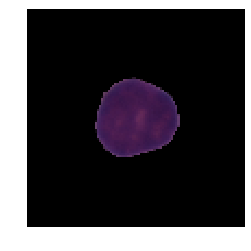

In [14]:
plt.imshow(data_tr["image"][4])
plt.axis("off")

True     7272
False    3389
Name: labels, dtype: int64

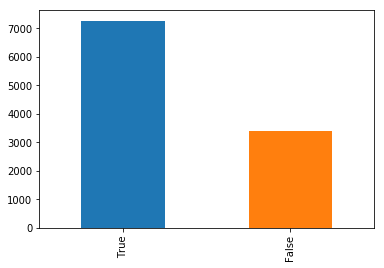

In [15]:
data_tr["labels"].value_counts().plot(kind = "bar")
data_tr["labels"].value_counts()

<Figure size 4320x4320 with 0 Axes>

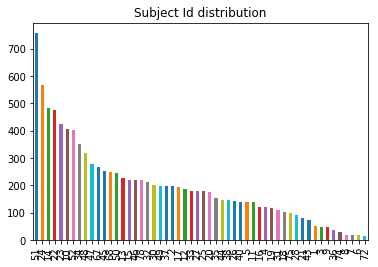

<Figure size 4320x4320 with 0 Axes>

In [16]:
data_tr['subject_id'].value_counts().plot(kind = 'bar')
plt.title("Subject Id distribution")
plt.figure(figsize = (60, 60))

In [17]:
data_tr["cell_no"] = data_tr["cell_no"].astype(np.int32)
data_tr["subject_id"] = data_tr["subject_id"].astype(np.int32)
data_tr["image_id"] = data_tr["image_id"].astype(np.int32)
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10661 entries, 0 to 10660
Data columns (total 7 columns):
Patient_ID    10661 non-null object
path          10661 non-null object
image         10661 non-null object
subject_id    10661 non-null int32
image_id      10661 non-null int32
cell_no       10661 non-null int32
labels        10661 non-null bool
dtypes: bool(1), int32(3), object(3)
memory usage: 385.3+ KB


In [18]:
X = data_tr.drop(["labels"], axis = 1)
y = data_tr["labels"]
X.head(4)

,Patient_ID,path,image,subject_id,image_id,cell_no
0,UID_H14_26_1_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",14,26,1
1,UID_H10_63_1_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",10,63,1
2,UID_H14_30_6_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",14,30,6
3,UID_H10_190_3_hem,../input/blood-cancer-training-dataset/c-nmc_t...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",10,190,3


%age of label value 0 in training dataset 0.32082551594746717
%age of label value 0 in test dataset 0.3061415846225973


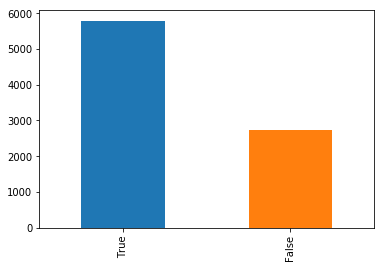

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

y_train.value_counts().plot(kind = "bar")

print("%age of label value 0 in training dataset", 
      y_train.value_counts()[0]/(y_train.value_counts()[0]+y_train.value_counts()[1]))
print("%age of label value 0 in test dataset", 
      y_test.value_counts()[0]/(y_test.value_counts()[0]+y_test.value_counts()[1]))

del X, y

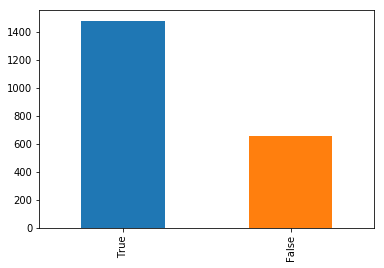

In [20]:
y_test.value_counts().plot(kind = "bar")

In [21]:
# Normalization
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_test_mean = np.mean(x_test)

x_train_std = np.std(x_train)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

y_dopetest = y_test
# Label Encoding
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

# Reshape images in 3 dimensions
x_train = x_train.reshape(x_train.shape[0], *(100, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 100, 3))
x_train.shape

(8528, 100, 100, 3)

## Defining models to train on our dataset

In [22]:
input_shape = (100, 100, 3)
num_classes = 2
# Set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, 
                                           factor = 0.5, min_lr = 0.00001)

# Data Augmentation
datagen = ImageDataGenerator(featurewise_center = False, samplewise_center = True,
                            featurewise_std_normalization = False, samplewise_std_normalization = False, 
                            zca_whitening = False, rotation_range = 0, zoom_range = 0.3, 
                            width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = False, 
                            vertical_flip = False, rescale = 1./255)
datagen.fit(x_train)
# print(datagen.mean, datagen.std)
# datagen.standardize(x_test)
print(x_test.shape)
for i in range(len(x_test)):
    # this is what you are looking for
    x_test[i] = datagen.standardize(x_test[i])
print(x_test.shape)

# Define the optimizer
# optimizer = Adam(lr = .001, beta_1 = .9, beta_2 = .999, epsilon = None, decay = .0, amsgrad = False)
# Fit the model
# 
# epochs = 20
# batch_size = 80

(2133, 100, 100, 3)
(2133, 100, 100, 3)


Defining and fitting Capsule network

In [ ]:

from __future__ import print_function
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
# from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator


# the squashing function.
# we use 0.5 instead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like time distributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'keras':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)


batch_size = 128
num_classes = 2
epochs = 1
# # (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# # x_train = x_train.astype('float32')
# # x_test = x_test.astype('float32')
# # x_train /= 255
# # x_test /= 255
# # y_train = utils.to_categorical(y_train, num_classes)
# # y_test = utils.to_categorical(y_test, num_classes)

# A common Conv2D model
input_image = Input(shape=(None, None, 3))
x = Conv2D(64, (3, 3), activation='relu')(input_image)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x = Reshape((-1, 128))(x)
capsule = Capsule(2, 16, 3, True)(x)
capsule = Dense(1, activation = 'sigmoid')(capsule)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model_caps = Model(inputs=input_image, outputs=output)

# we use a margin loss
model_caps.compile(loss=margin_loss, optimizer= optimizers.Adam(lr = 0.001), metrics=['mae', 'acc'])
model_caps.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

if not data_augmentation:
    print('Not using data augmentation.')
    model_caps.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        steps_per_epoch = x_train.shape[0] // batch_size)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen1 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(
        datagen1.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        steps_per_epoch = x_train.shape[0] // batch_size,
        workers=4)



### SeResnext model

In [26]:
input_shape = (100, 100, 3)
num_classes = 2
batch_size = 128
# Data Augmentation
datagen = ImageDataGenerator(featurewise_center = False, samplewise_center = True,
                            featurewise_std_normalization = False, samplewise_std_normalization = True, 
                            zca_whitening = False, rotation_range = 0.3, zoom_range = 0.3, 
                            width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = True, 
                            vertical_flip = False, rescale = 1./255)
datagen.fit(x_train)
# print(datagen.mean, datagen.std)
# datagen.standardize(x_test)
print(x_test.shape)
for i in range(len(x_test)):
    # this is what you are looking for
    x_test[i] = datagen.standardize(x_test[i])
print(x_test.shape)

(2133, 100, 100, 3)
(2133, 100, 100, 3)


In [33]:

from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np

from keras.models import Model
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import Reshape

from keras.layers import Conv2D
from keras.layers import Activation
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Dense

from keras.layers import Concatenate, concatenate
from keras.layers import Add, add
from keras.layers import Multiply, multiply

from keras import backend as K
batch_size = 128
epochs = 30

class SEResNeXt(object):
    def __init__(self, size= 100, num_classes= 2, depth=32, reduction_ratio=4, num_split=8, num_block=3):
        self.depth = depth  # number of channels
        self.ratio = reduction_ratio  # ratio of channel reduction in SE module
        self.num_split = num_split  # number of splitting trees for ResNeXt (so called cardinality)
        self.num_block = num_block  # number of residual blocks
        if K.image_data_format() == 'channels_first':
            self.channel_axis = 1
        else:
            self.channel_axis = 3
        self.model_senet = Sequential()
        self.model_senet = self.build_model(Input(shape=(size,size,3)), num_classes)
        print(self.model_senet.summary())
        self.model_senet.compile(optimizer = "Adamax", loss = "categorical_crossentropy", metrics = ["accuracy"])
        self.hist = self.model_senet.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
        validation_data=(x_test, y_test), steps_per_epoch = x_train.shape[0] // batch_size, workers=4)
        print(self.hist)
    
    def conv_bn(self, x, filters, kernel_size, stride, padding='same'):
        '''
        Combination of Conv and BN layers since these always appear together.
        '''
        x = Conv2D(filters=filters, kernel_size=[kernel_size, kernel_size],
                   strides=[stride, stride], padding=padding)(x)
        x = BatchNormalization()(x)
        
        return x
    
    def activation(self, x, func='relu'):
        '''
        Activation layer.
        '''
        return Activation(func)(x)
    
    def channel_zeropad(self, x):
        '''
        Zero-padding for channle dimensions.
        Note that padded channles are added like (Batch, H, W, 2/x + x + 2/x).
        '''
        shape = list(x.shape)
        y = K.zeros_like(x)
        
        if self.channel_axis == 3:
            y = y[:, :, :, :shape[self.channel_axis] // 2]
        else:
            y = y[:, :shape[self.channel_axis] // 2, :, :]
        
        return concatenate([y, x, y], self.channel_axis)
    
    def channel_zeropad_output(self, input_shape):
        '''
        Function for setting a channel dimension for zero padding.
        '''
        shape = list(input_shape)
        shape[self.channel_axis] *= 2

        return tuple(shape)
    
    def initial_layer(self, inputs):
        '''
        Initial layers includes {conv, BN, relu}.
        '''
        x = self.conv_bn(inputs, self.depth, 3, 1)
        x = self.activation(x)
        
        return x
    
    def transform_layer(self, x, stride):
        '''
        Transform layer has 2 {conv, BN, relu}.
        '''
        x = self.conv_bn(x, self.depth, 1, 1)
        x = self.activation(x)
        
        x = self.conv_bn(x, self.depth, 3, stride)
        x = self.activation(x)
        
        return x
        
    def split_layer(self, x, stride):
        '''
        Parallel operation of transform layers for ResNeXt structure.
        '''
        splitted_branches = list()
        for i in range(self.num_split):
            branch = self.transform_layer(x, stride)
            splitted_branches.append(branch)
        
        return concatenate(splitted_branches, axis=self.channel_axis)
    
    def squeeze_excitation_layer(self, x, out_dim):
        '''
        SE module performs inter-channel weighting.
        '''
        squeeze = GlobalAveragePooling2D()(x)
        
        excitation = Dense(units=out_dim // self.ratio)(squeeze)
        excitation = self.activation(excitation)
        excitation = Dense(units=out_dim)(excitation)
        excitation = self.activation(excitation, 'sigmoid')
        excitation = Reshape((1,1,out_dim))(excitation)
        
        scale = multiply([x,excitation])
        
        return scale
    
    def residual_layer(self, x, out_dim):
        '''
        Residual block.
        '''
        for i in range(self.num_block):
            input_dim = int(np.shape(x)[-1])
            
            if input_dim * 2 == out_dim:
                flag = True
                stride = 2
            else:
                flag = False
                stride = 1
            
            subway_x = self.split_layer(x, stride)
            subway_x = self.conv_bn(subway_x, out_dim, 1, 1)
            subway_x = self.squeeze_excitation_layer(subway_x, out_dim)
            
            if flag:
                pad_x = AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
                pad_x = Lambda(self.channel_zeropad, output_shape=self.channel_zeropad_output)(pad_x)
            else:
                pad_x = x
            
            x = self.activation(add([pad_x, subway_x]))
                
        return x
    
    def build_model(self, inputs, num_classes):
        '''
        Build a SeResnext model.
        '''
        x = self.initial_layer(inputs)
        
        x = self.residual_layer(x, out_dim=64)
        x = self.residual_layer(x, out_dim=128)
        x = self.residual_layer(x, out_dim=256)
        
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=num_classes, activation='softmax')(x)
        
        return Model(inputs, x)

In [34]:
model_senet = SEResNeXt()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_463 (Conv2D)             (None, 100, 100, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_463 (BatchN (None, 100, 100, 32) 128         conv2d_463[0][0]                 
__________________________________________________________________________________________________
activation_517 (Activation)     (None, 100, 100, 32) 0           batch_normalization_463[0][0]    
__________________________________________________________________________________________________
conv2d_464

Epoch 1/30
66/66 [==============================] - 132s 2s/step - loss: 0.5081 - acc: 0.7599 - val_loss: 0.4633 - val_acc: 0.7876
Epoch 2/30
66/66 [==============================] - 55s 829ms/step - loss: 0.3878 - acc: 0.8342 - val_loss: 0.3898 - val_acc: 0.8364
Epoch 3/30
66/66 [==============================] - 55s 831ms/step - loss: 0.3460 - acc: 0.8526 - val_loss: 0.4953 - val_acc: 0.7661
Epoch 4/30
66/66 [==============================] - 55s 835ms/step - loss: 0.3376 - acc: 0.8631 - val_loss: 0.3397 - val_acc: 0.8664
Epoch 5/30
66/66 [==============================] - 55s 837ms/step - loss: 0.3144 - acc: 0.8746 - val_loss: 0.3493 - val_acc: 0.8472
Epoch 6/30
66/66 [==============================] - 55s 832ms/step - loss: 0.3071 - acc: 0.8770 - val_loss: 0.5415 - val_acc: 0.8036
Epoch 7/30
66/66 [==============================] - 55s 829ms/step - loss: 0.2922 - acc: 0.8830 - val_loss: 0.4171 - val_acc: 0.8458
Epoch 8/30
66/66 [==============================] - 55s 830ms/step - lo

Text(0, 0.5, 'Accuracy')

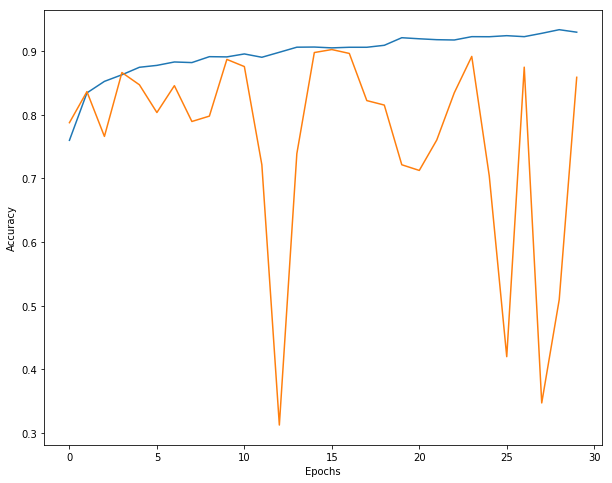

In [35]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(model_senet.hist.history['acc'])
plt.plot(model_senet.hist.history['val_acc'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

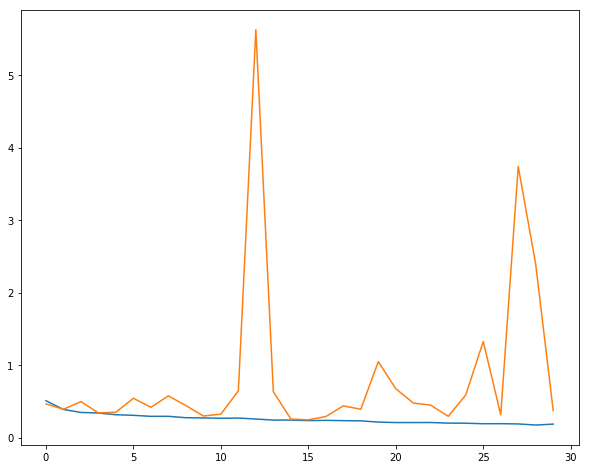

In [36]:
plt.plot(model_senet.hist.history['loss'])
plt.plot(model_senet.hist.history['val_loss'])

### Fitting our pretrained models

Densenet

In [ ]:
from keras.applications.densenet import DenseNet121

batch_size = 128
num_classes = 2
epochs = 10

model_densenet = Sequential()
model_densenet.add(DenseNet121(include_top=False, pooling= 'max', weights = 'imagenet'))
model_densenet.add(BatchNormalization())
model_densenet.add(Activation("tanh"))
model_densenet.add(Dropout(0.40))
model_densenet.add(Dense(num_classes, activation = "sigmoid"))

# model_densenet.layers[0].trainable = False
# model_densenet.layers[1].trainable = False

model_densenet.compile(optimizer = "Adamax", loss = "categorical_crossentropy", 
                       metrics = ['mae', 'accuracy'])

datagen = ImageDataGenerator(featurewise_center=True,  # set input mean to 0 over the dataset
                             samplewise_center=False,  # set each sample mean to 0
                             featurewise_std_normalization=True,  # divide inputs by dataset std
                             samplewise_std_normalization=False,  # divide each input by its std
                             zca_whitening=False,  # apply ZCA whitening
                             zca_epsilon=1e-06,  # epsilon for ZCA whitening
                             rotation_range=0.2,  # randomly rotate images in 0 to 180 degrees
                             width_shift_range=0.1,  # randomly shift images horizontally
                             height_shift_range=0.1,  # randomly shift images vertically
                             shear_range=0.,  # set range for random shear
                             zoom_range=0.3,  # set range for random zoom
                             channel_shift_range=0,  # set range for random channel shifts
                             # set mode for filling points outside the input boundaries
                             fill_mode='nearest',
                             cval=0.,  # value used for fill_mode = "constant"
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=False,  # randomly flip images
                             # set rescaling factor (applied before any other transformation)
                             rescale=1./255,
                             # set function that will be applied on each input
                             preprocessing_function=None,
                             # image data format, either "channels_first" or "channels_last"
                             data_format=None,
                             # fraction of images reserved for validation (strictly between 0 and 1)
                             validation_split=0.0)
datagen.fit(x_train)
# print(datagen.mean, datagen.std)
# datagen.standardize(x_test)
print(x_test.shape)
for i in range(len(x_test)):
    # this is what you are looking for
    x_test[i] = datagen.standardize(x_test[i])
print(x_test.shape)


print("*"*40 + "Densenet model" + "*"*40)
history = model_densenet.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           verbose = 1,
                           epochs = 3,
                           steps_per_epoch= x_train.shape[0] // batch_size, 
                            callbacks = [learning_rate_reduction],
                           validation_data = (x_test, y_test))

In [ ]:
model_densenet.evaluate(x_test, y_test)

### Defining ResNeXt50 model

In [ ]:
# sys.path.append('/kaggle/working/isbi2019cancer/')
# import isbi2019cancer.utils
# sys.modules["utils"] = isbi2019cancer.utils
# import isbi2019cancer.model as model_jprell

In [ ]:
'''ResNeXt models for Keras.
# Reference
- [Aggregated Residual Transformations for Deep Neural Networks](https://arxiv.org/pdf/1611.05431.pdf))
'''
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings

from keras.models import Model
from keras.layers.core import Dense, Lambda
from keras.layers.core import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D
from keras.layers import Input
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
# from keras.applications.imagenet_utils import _obtain_input_shape
import keras.backend as K

CIFAR_TH_WEIGHTS_PATH = ''
CIFAR_TF_WEIGHTS_PATH = ''
CIFAR_TH_WEIGHTS_PATH_NO_TOP = ''
CIFAR_TF_WEIGHTS_PATH_NO_TOP = ''

IMAGENET_TH_WEIGHTS_PATH = ''
IMAGENET_TF_WEIGHTS_PATH = ''
IMAGENET_TH_WEIGHTS_PATH_NO_TOP = ''
IMAGENET_TF_WEIGHTS_PATH_NO_TOP = ''

In [ ]:
def __create_res_next_imagenet(nb_classes, img_input, include_top, depth, cardinality=32, width=4,
                               weight_decay=5e-4, pooling=None):
    ''' Creates a ResNeXt model with specified parameters
    Args:
        nb_classes: Number of output classes
        img_input: Input tensor or layer
        include_top: Flag to include the last dense layer
        depth: Depth of the network. List of integers.
               Increasing cardinality improves classification accuracy,
        width: Width of the network.
        weight_decay: weight_decay (l2 norm)
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
    Returns: a Keras Model
    '''

    if type(depth) is list or type(depth) is tuple:
        # If a list is provided, defer to user how many blocks are present
        N = list(depth)
    else:
        # Otherwise, default to 3 blocks each of default number of group convolution blocks
        N = [(depth - 2) // 9 for _ in range(3)]

    filters = cardinality * width
    filters_list = []

    for i in range(len(N)):
        filters_list.append(filters)
        filters *= 2  # double the size of the filters

    x = __initial_conv_block_imagenet(img_input, weight_decay)

    # block 1 (no pooling)
    for i in range(N[0]):
        x = __bottleneck_block(x, filters_list[0], cardinality, strides=1, weight_decay=weight_decay)

    N = N[1:]  # remove the first block from block definition list
    filters_list = filters_list[1:]  # remove the first filter from the filter list

    # block 2 to N
    for block_idx, n_i in enumerate(N):
        for i in range(n_i):
            if i == 0:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=2,
                                       weight_decay=weight_decay)
            else:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=1,
                                       weight_decay=weight_decay)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  kernel_initializer='he_normal', activation='softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    return x

def __initial_conv_block_imagenet(input, weight_decay=5e-4):
    ''' Adds an initial conv block, with batch norm and relu for the inception resnext
    Args:
        input: input tensor
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(64, (7, 7), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay), strides=(2, 2))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    return x

def __bottleneck_block(input, filters=64, cardinality=8, strides=1, weight_decay=5e-4):
    ''' Adds a bottleneck block
    Args:
        input: input tensor
        filters: number of output filters
        cardinality: cardinality factor described number of
            grouped convolutions
        strides: performs strided convolution for downsampling if > 1
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
    init = input

    grouped_channels = int(filters / cardinality)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 16 * k, else create convolution2d for this input
    if K.image_data_format() == 'channels_first':
        if init._keras_shape[1] != 2 * filters:
            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
            init = BatchNormalization(axis=channel_axis)(init)
    else:
        if init._keras_shape[-1] != 2 * filters:
            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
            init = BatchNormalization(axis=channel_axis)(init)

    x = Conv2D(filters, (1, 1), padding='same', use_bias=False,
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = __grouped_convolution_block(x, grouped_channels, cardinality, strides, weight_decay)

    x = Conv2D(filters * 2, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=channel_axis)(x)

    x = add([init, x])
    x = Activation('relu')(x)

    return x


def __grouped_convolution_block(input, grouped_channels, cardinality, strides, weight_decay=5e-4):
    ''' Adds a grouped convolution block. It is an equivalent block from the paper
    Args:
        input: input tensor
        grouped_channels: grouped number of filters
        cardinality: cardinality factor describing the number of groups
        strides: performs strided convolution for downscaling if > 1
        weight_decay: weight decay term
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    group_list = []

    if cardinality == 1:
        # with cardinality 1, it is a standard convolution
        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
        x = BatchNormalization(axis=channel_axis)(x)
        x = Activation('relu')(x)
        return x

    for c in range(cardinality):
        x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels]
        if K.image_data_format() == 'channels_last' else
        lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :, :])(input)

        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

        group_list.append(x)

    group_merge = concatenate(group_list, axis=channel_axis)
    x = BatchNormalization(axis=channel_axis)(group_merge)
    x = Activation('relu')(x)

    return x

In [ ]:
input_shape = (100, 100, 3)
num_classes = 2
batch_size = 128
# Data Augmentation
datagen = ImageDataGenerator(featurewise_center = False, samplewise_center = True,
                            featurewise_std_normalization = False, samplewise_std_normalization = True, 
                            zca_whitening = False, rotation_range = 0.3, zoom_range = 0.3, 
                            width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = True, 
                            vertical_flip = False, rescale = 1./255)
datagen.fit(x_train)
# print(datagen.mean, datagen.std)
# datagen.standardize(x_test)
print(x_test.shape)
for i in range(len(x_test)):
    # this is what you are looking for
    x_test[i] = datagen.standardize(x_test[i])
print(x_test.shape)

In [ ]:
def ResNextImageNet(input_shape, depth, cardinality, width, weight_decay, pooling, classes, 
                    include_top= False, weights=None, input_tensor=None):
    """ Instantiate the ResNeXt architecture for the ImageNet dataset. Note that ,
        when using TensorFlow for best performance you should set
        `image_data_format="channels_last"` in your Keras config
        at ~/.keras/keras.json.
        The model are compatible with both
        TensorFlow and Theano. The dimension ordering
        convention used by the model is the one
        specified in your Keras config file.
        # Arguments
            depth: number or layers in the each block, defined as a list.
                ResNeXt-50 can be defined as [3, 4, 6, 3].
                ResNeXt-101 can be defined as [3, 4, 23, 3].
                Defaults is ResNeXt-50.
            cardinality: the size of the set of transformations
            width: multiplier to the ResNeXt width (number of filters)
            weight_decay: weight decay (l2 norm)
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: `None` (random initialization) or `imagenet` (trained
                on ImageNet)
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False (otherwise the input shape
                has to be `(224, 224, 3)` (with `tf` dim ordering)
                or `(3, 224, 224)` (with `th` dim ordering).
                It should have exactly 3 inputs channels,
                and width and height should be no smaller than 8.
                E.g. `(200, 200, 3)` would be one valid value.
            pooling: Optional pooling mode for feature extraction
                when `include_top` is `False`.
                - `None` means that the output of the model will be
                    the 4D tensor output of the
                    last convolutional layer.
                - `avg` means that global average pooling
                    will be applied to the output of the
                    last convolutional layer, and thus
                    the output of the model will be a 2D tensor.
                - `max` means that global max pooling will
                    be applied.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
        # Returns
            A Keras model instance.
        """

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if type(depth) == int and (depth - 2) % 9 != 0:
        raise ValueError('Depth of the network must be such that (depth - 2)'
                         'should be divisible by 9.')
    # Determine proper input shape
#     input_shape = _obtain_input_shape(input_shape,
#                                       default_size=224,
#                                       min_size=112,
#                                       data_format=K.image_data_format(),
#                                       require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_res_next_imagenet(classes, img_input, include_top, depth, cardinality, width,
                                   weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnext')

    # load weights
    if weights == 'imagenet':
        if (depth == [3, 4, 6, 3]) and (cardinality == 32) and (width == 4):
            # Default parameters match. Weights for this model exist:

            if K.image_data_format() == 'channels_first':
                if include_top:
                    weights_path = get_file('resnext_imagenet_32_4_th_dim_ordering_th_kernels.h5',
                                            IMAGENET_TH_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_imagenet_32_4_th_dim_ordering_th_kernels_no_top.h5',
                                            IMAGENET_TH_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'tensorflow':
                    warnings.warn('You are using the TensorFlow backend, yet you '
                                  'are using the Theano '
                                  'image dimension ordering convention '
                                  '(`image_dim_ordering="th"`). '
                                  'For best performance, set '
                                  '`image_dim_ordering="tf"` in '
                                  'your Keras config '
                                  'at ~/.keras/keras.json.')
                    convert_all_kernels_in_model(model)
            else:
                if include_top:
                    weights_path = get_file('resnext_imagenet_32_4_tf_dim_ordering_tf_kernels.h5',
                                            IMAGENET_TF_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_imagenet_32_4_tf_dim_ordering_tf_kernels_no_top.h5',
                                            IMAGENET_TF_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'theano':
                    convert_all_kernels_in_model(model)

    return model

In [ ]:
model_resnext = Sequential()
model_resnext.add(ResNextImageNet(input_shape= input_shape, depth=[3, 4, 6, 3], cardinality=32, width=4, 
                                weight_decay=5e-4, include_top= False, weights=None, input_tensor=None, 
                                pooling= 'max', classes= 1000))
model_resnext.add(Dropout(.3))
model_resnext.add(Dense(num_classes, activation = "sigmoid"))

In [ ]:
model_resnext.summary()

In [ ]:
model_resnext.compile(optimizer = "Adamax", loss = 'categorical_crossentropy', metrics = ['mae', 'accuracy'])

In [ ]:
model_resnext.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), verbose = 1, 
                           epochs = 20,
                           steps_per_epoch= x_train.shape[0] // batch_size, 
                            callbacks = [learning_rate_reduction],
                           validation_data = (x_test, y_test))

In [ ]:
model_resnext.evaluate(x_test, y_test, verbose = 1)

In [ ]:
# model_se_net = Sequential()
# model_se_net.add(model_senet)
# model_se_net.add(Dense(num_classes, activation = 'sigmoid'))
# model_senet.compile(optimizer = "Adamax", loss = 'categorical_crossentropy', metrics = ['mae', 'accuracy'])

In [ ]:
!git clone https://github.com/titu1994/Keras-ResNeXt

In [ ]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.applications import ResNet50, VGG16, VGG19, InceptionV3
# Using pretrained models for VGG16, VGG19, resnet, InceptionV3
# If you are using Kaggle kernel, do switch ON the Internet from Settings.
# from keras.applications.resnext import ResNeXt50
# from keras.applications.nasnet import NASNetMobile
# model_nasnet = Sequential()
# model_nasnet.add(NASNetMobile(include_top = None, input_shape = (100, 100, 3), pooling='max'))
# model_nasnet.add(Dense(num_classes, activation = "sigmoid"))

# from keras.applications.mobilenet_v2 import MobileNetV2
# model_mobile = Sequential()
# model_mobile.add(MobileNetV2(input_shape=None, alpha=1.0, 
#                         include_top=False, weights='imagenet', input_tensor=None, pooling='max'))
# model_mobile.add(Dense(num_classes, activation = "softmax"))

# model_resnet = Sequential()
# model_resnet.add(ResNet50(include_top=False, pooling='max', weights= "imagenet"))
# model_resnet.add(Dense(num_classes, activation='softmax'))

# model_vgg16 = Sequential()
# model_vgg16.add(VGG16(include_top= False, pooling = "max", weights = "imagenet"))
# model_vgg16.add(Dense(num_classes, activation = "softmax"))

model_vgg19 = Sequential()
model_vgg19.add(VGG19(include_top= False, pooling = "max", weights = "imagenet"))
model_vgg19.add(Dense(num_classes, activation = "softmax"))

# model_inception = Sequential()
# model_inception.add(InceptionV3(include_top= False, pooling = "max", weights = "imagenet"))
# model_inception.add(Dense(num_classes, activation = "softmax"))

# Say not to train first layer (ResNet) model. It is already trained
# model_nasnet.layers[0].trainable = False
# model_mobile.layers[0].trainable = False
# model_resnet.layers[0].trainable = False
# model_vgg16.layers[0].trainable = False
model_vgg19.layers[0].trainable = False
# model_inception.layers[0].trainable = False

In [ ]:
# Compile the pretrained models
# model_nasnet.compile(optimizer= "Adamax", loss='categorical_crossentropy', metrics=['accuracy'])

# model_mobile.compile(optimizer= "Adamax", loss='categorical_crossentropy', metrics=['accuracy'])

# model_resnet.compile(optimizer= "Adamax", loss='categorical_crossentropy', metrics=['accuracy'])

# model_vgg16.compile(optimizer = "Adamax", loss = "categorical_crossentropy", metrics = ['accuracy'])

model_vgg19.compile(optimizer = "Adamax", loss = "categorical_crossentropy", metrics = ['mae', 'accuracy'])

# model_inception.compile(optimizer = 'Adamax', loss = "categorical_crossentropy", metrics = ['accuracy'])

datagen = ImageDataGenerator(featurewise_center = False, samplewise_center = True,
                            featurewise_std_normalization = False, samplewise_std_normalization = True, 
                            zca_whitening = False, rotation_range = 0, zoom_range = 0.3, 
                            width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = False, 
                            vertical_flip = False, rescale = 1./255)
datagen.fit(x_train)
# print(datagen.mean, datagen.std)
# datagen.standardize(x_test)
print(x_test.shape)
for i in range(len(x_test)):
    # this is what you are looking for
    x_test[i] = datagen.standardize(x_test[i])
print(x_test.shape)

In [ ]:
import random
random.seed(1234)
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,
#                               patience=3, min_lr=0.001)
# Fit the model
# print("*"*40 + "Nasnet model" + "*"*40)
# history = model_nasnet.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                            verbose = 0,
#                            epochs = epochs,
#                            steps_per_epoch=x_train.shape[0] // batch_size,
#                                      callbacks = [learning_rate_reduction],
#                            validation_data = (x_test, y_test))

# print("*"*40 + "Mobile model" + "*"*40)
# history = model_mobile.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                            verbose = 0,
#                            epochs = epochs,
#                            steps_per_epoch=x_train.shape[0] // batch_size,
#                                      callbacks = [learning_rate_reduction],
#                            validation_data = (x_test, y_test))

# print("*"*40 + "ResNet50 model" + "*"*40)
# history = model_resnet.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                            verbose = 1,
#                            epochs = epochs,
#                            steps_per_epoch=x_train.shape[0] // batch_size,
#                                      callbacks = [learning_rate_reduction],
#                            validation_data = (x_test, y_test))
# print("*"*40 + "VGG16 model" + "*"*40)
# history = model_vgg16.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                            verbose = 1,
#                            epochs = epochs,
#                            steps_per_epoch=x_train.shape[0] // batch_size, 
#                             callbacks = [learning_rate_reduction], 
#                             validation_data = (x_test, y_test))
batch_size = 128
num_classes = 2
epochs = 10
print("*"*40 + "VGG19 model" + "*"*40)
history = model_vgg19.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           verbose = 1,
                           epochs = epochs,
                           steps_per_epoch= x_train.shape[0] // batch_size, 
                            callbacks = [learning_rate_reduction],
                           validation_data = (x_test, y_test))

# print("*"*40 + "inception model" + "*"*40)
# history = model_inception.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                            verbose = 1,
#                            epochs = epochs,
#                            steps_per_epoch=x_train.shape[0] // batch_size,
#                             callbacks = [learning_rate_reduction], 
#                            validation_data = (x_test, y_test))

In [ ]:
from os import makedirs
# makedirs('models')
# fit and save models
filename = 'models/model_caps.h5'
model_caps.save(filename)
print('>Saved %s' % filename)
# filename = 'models/model_densenet.h5'
# model_densenet.save(filename)
# print('>Saved %s' % filename)
filename = 'models/model_VGG19.h5'
model_vgg19.save(filename)
print('>Saved %s' % filename)
filename = 'models/model_resnext.h5'
model_resnext.save(filename)
print('>Saved %s' % filename)

In [ ]:
print(model_caps.evaluate(x_test, y_test, verbose = 0))
model_caps.metrics_names

In [ ]:
print(model_vgg19.evaluate(x_test, y_test, verbose = 0))
# model_caps.metrics_names

In [ ]:
print(model_resnext.evaluate(x_test, y_test, verbose = 0))
model_resnext.metrics_names

In [ ]:
print(model_densenet.evaluate(x_test, y_test, verbose = 0))
model_densenet.metrics_names

In [ ]:
# from keras.models import load_model
members = []
# filename = 'models/model_caps.h5'
# model = load_model(filename)
members.append(model_caps)
# filename = 'models/model_VGG19.h5'
# model = load_model(filename)
members.append(model_vgg19)
# del model
# members.append(model_densenet)
members.append(model_resnext)
members

In [ ]:
for model in members:
    acc = model.evaluate(x_test, y_test, verbose=0)[-1]
    print('Model Accuracy: %.3f' % acc)
model_vgg19.predict(x_test, verbose=0).shape

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = np.dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = LogisticRegression()
    model.fit(stackedX, inputy)
    return model

# fit stacked model using the ensemble
model = fit_stacked_model(members, x_test, y_dopetest)

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

# evaluate model on test set
yhat = stacked_prediction(members, model, x_test)
acc = accuracy_score(y_dopetest, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

In [ ]:
# from keras.applications.resnet import ResNet152
# model_dop = ResNet152(include_top=False, weights='imagenet', pooling="max")
# model_dop.add(Dense(num_classes, activation = "softmax"))
# model_dop.layers[0].trainable = False
# model_dop.compile(optimizer= "Adamax", loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
# print("*"*40 + "ResNeXt101 model" + "*"*40)
# history = model_dop.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                            verbose = 1,
#                            epochs = epochs,
#                            steps_per_epoch=x_train.shape[0] // batch_size,
#                                      callbacks = [learning_rate_reduction],
#                            validation_data = (x_test, y_test))

Dataset Reference :- [CodaLab_competition](https://competitions.codalab.org/competitions/20429#learn_the_details-terms_and_conditions)

| Model/Architecture | Type | Optimizer | Accuracy(in %) |
| --- | --- | --- | --- |
| CNN | Raw | Adam | ~65 ||
| ResNet50 | Pre-Trained | sgd | ~64 |
| VGG16 | Pre-Trained | sgd | ~77 |
| VGG19 | Pre-Trained | sgd | ~79 |
| Inception | Pre-Trained | sgd | ~64 |
| VGG16 | Pre-Trained | Adam | ~81 |
| VGG19 | Pre-Trained | Adam | ~83 |
| VGG16 | Pre-Trained | Adamax | ~79 |
| VGG19 | Pre-Trained | Adamax | ~78 |
| VGG16 | Pre-Trained | Nadam | ~80 |
| VGG19 | Pre-Trained | Nadam | ~79 |